In [1]:
from xgboost import XGBClassifier
import pandas as pd
from glance.iterative_merges.iterative_merges import C_GLANCE
from glance.counterfactual_tree.counterfactual_tree import T_GLANCE
from glance.utils.utils_data import preprocess_datasets,load_models

In [2]:
dataset = "compas"
model_name = "xgb"

train_dataset, data, X_train, y_train, X_test, y_test, affected, _unaffected, model, feat_to_vary, target_name = (
    preprocess_datasets(dataset, load_models(dataset, model_name), model_name)
)

models/compas_xgb.pkl
[16:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

Accuracy: 0.68


# C-GLANCE

In [3]:
global_method = C_GLANCE(
    model,
    initial_clusters=100,
    final_clusters=3,
    num_local_counterfactuals=10,
)
global_method.fit(
    data.drop(columns=["Status"]),
    data["Status"],
    train_dataset,
    feat_to_vary,
)

In [4]:
clusters, clusters_res = global_method.explain_group(affected)

100%|██████████| 370/370 [00:08<00:00, 43.07it/s]


Action 1 
Age_Cat = Greater than 45 

Effectiveness: 99.40%	Cost: 1.00


Action 2 
Race = Hispanic 
Priors_Count -24.2 

Effectiveness: 98.53%	Cost: 7.28


Action 3 
Race = Asian 
Priors_Count -7.5 

Effectiveness: 100.00%	Cost: 2.87


TOTAL EFFECTIVENESS: 99.60%
TOTAL COST: 1.94


# C-GLANCE with Nearest Neighbors Local Cfs

In [6]:
global_method = C_GLANCE(
    model, initial_clusters=100, final_clusters=3, num_local_counterfactuals=10
)
global_method.fit(
    data.drop(columns=["Status"]),
    data["Status"],
    train_dataset,
    feat_to_vary,
    cf_generator="NearestNeighbors",
)

In [7]:
clusters, clusters_res = global_method.explain_group(affected)

100%|███████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 192.66it/s]


Action 1 
Sex = Female 
Age_Cat = Greater than 45 
C_Charge_Degree = M 
Priors_Count -13.0 
Time_Served -8.0 

Effectiveness: 98.13%	Cost: 6.07


Action 2 
Age_Cat = Greater than 45 
Race = Caucasian 
Priors_Count -21.0 
Time_Served -5.0 

Effectiveness: 99.40%	Cost: 7.05


Action 3 
Age_Cat = Greater than 45 
Priors_Count -0.23076923076923084 
Time_Served +0.3846153846153846 

Effectiveness: 100.00%	Cost: 1.18


TOTAL EFFECTIVENESS: 99.60%
TOTAL COST: 2.40


# T-GLANCE

In [3]:
global_method_args_fit = {}
global_method_args_fit["train_dataset"] = train_dataset

In [4]:
cf_tree = T_GLANCE(model)
cf_tree.fit(data.drop(columns=["Status"]), data["Status"], train_dataset)

In [5]:
node = cf_tree.partition_group(affected.loc[0:10])

100%|██████████| 15/15 [00:00<00:00, 25.75it/s]


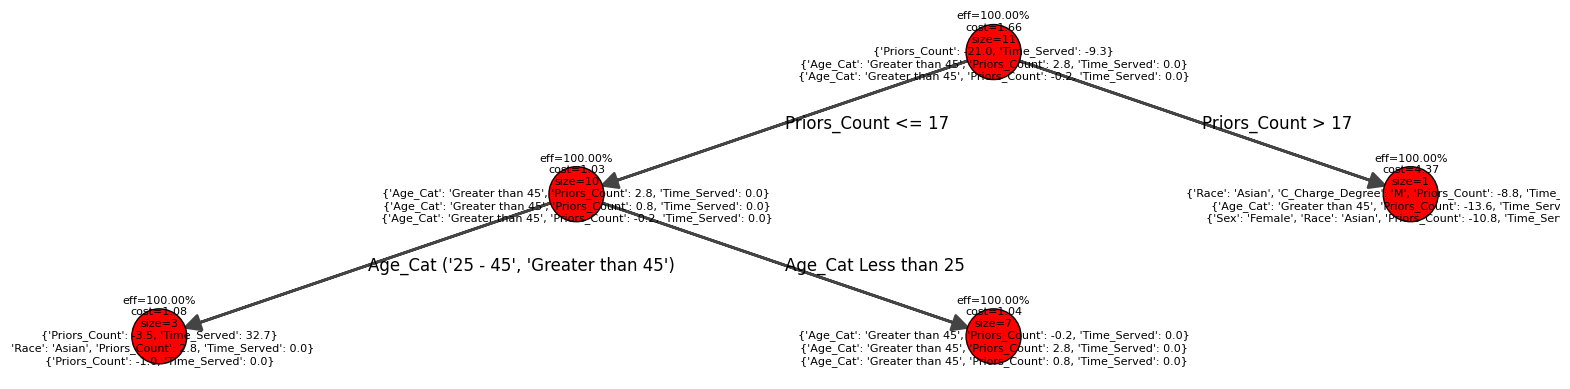

In [6]:
node.display_igraph_jupyter(
    numeric_features=affected.select_dtypes(
        include=["number"]).columns.tolist()
)

In [7]:
cf_tree.cumulative_leaf_actions()


TOTAL EFFECTIVENESS: 100.00%

TOTAL COST: 1.20


(11, 13.157894736842106, 9)